## Paper information
Song, Y., & Ermon, S. (2020). Improved techniques for training score-based generative models.  
Advances in neural information processing systems, 33, 12438-12448.

## Code authors
Merve Tapli (mtapli@ceng.metu.edu.tr)
Sezai Artun Ozyegin (artunozyegin@gmail.com)

## Refered papers

[1] Improved Techniques for Training Score-Based Generative Models. NeurIPS 2020 https://arxiv.org/pdf/2006.09011.pdf

[2] Generative modeling by estimating gradients of the data distribution. NeurIPS 2019 https://arxiv.org/pdf/1907.05600.pdf

[3] RefineNet: Multi-Path Refinement Networks for High-Resolution Semantic Segmentation. CVPR 2017 https://arxiv.org/pdf/1611.06612.pdf

[4] GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium. NeurIPS 2017 https://arxiv.org/pdf/1706.08500.pdf

In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from model import NCSNv2
from scipy.stats import norm
from dataset import get_dataloader
from collections import namedtuple
from utils import get_name, parse_arguments, calculate_noise_scales
from train import train
from test import test

%load_ext autoreload
%autoreload 2

## Hyperparameters

The paper's main contribution is the theoratical analysis of the score based generative models. It provides several techniques to improve the performance by configuring the training of the NCSN model and sampling from the model. They, gave further insight into how we should select the hyperparameters and made some theoretical analysis on them. Therefore, here, we discuss how these hyperparamters are calculated; although we have used readily calculated ones given in the paper in our experiments.

In [2]:
Args = namedtuple('Args', ['cuda',
                           'wandb',
                           'wandb_entity',
                           'dataset',
                           'batch_size',
                           'epochs',
                           'lr',
                           'L',
                           'sigma1',
                           'eps',
                           'T',
                           'reduction'])
args = Args(
    cuda = True,
    wandb = False,
    wandb_entity = None,
    dataset = 'CIFAR10',
    batch_size = 128,
    epochs = 770,
    lr = 1e-4, # learning rate
    L = 232, # the number of noise scales
    sigma1 = 50, # the largest noise scale
    eps = 6.2e-6, # the scaling constant used in step-size calculation
    T = 5, # the number of iterations done at every noise scale in Annealed Langevin Dynamics
    reduction = 'mean'
)

In [3]:
device = torch.device('cuda' if args.cuda else 'cpu')

**Technique 1** (Initial noise scale). *Choose sigma1 to be as large as the maximum Euclidean distance between all pairs of training data points.*

In [4]:
dataloader1 = get_dataloader('CIFAR10', True, 5000)
dataloader2 = get_dataloader('CIFAR10', True, 5000)

max_l2_dist = 0
for images1, _ in tqdm(dataloader1):
    images1 = images1.to(device)
    for images2, _ in dataloader2:
        images2 = images2.to(device)
        l2_dist = torch.cdist(images1.view(1, images1.size(0), -1), images2.view(1, images2.size(0), -1))
        current_max = torch.max(l2_dist).item()
        if current_max > max_l2_dist:
            max_l2_dist = current_max

print('Maximum L2 distance between CIFAR10 images:', max_l2_dist)

Files already downloaded and verified
Files already downloaded and verified


100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]

Maximum L2 distance between CIFAR10 images: 53.414981842041016


**Technique 2** (Other noise scales). *Choose sigma_i as a geometric progression with common ratio γ, such that Φ(√2D(γ − 1) + 3γ) − Φ(√2D(γ − 1) −  γ) ≈ 0.5 .*

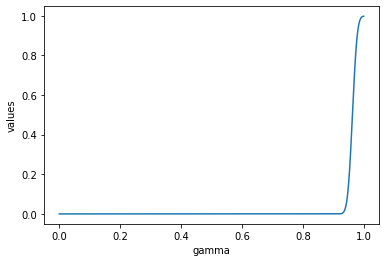

Calculated gamma: 0.9630963096309632
The value we calculated from the other values given in [1]: 0.9638


In [5]:
# The dimension for a CIFAR10 image 
D = 32*32*3
gamma = np.linspace(0, 1, 10000)
values = norm.cdf(np.sqrt(2*D) * (gamma - 1) + 3 * gamma) - norm.cdf(np.sqrt(2*D) * (gamma - 1) - 3 * gamma)
plt.plot(gamma, values)
plt.xlabel('gamma')
plt.ylabel('values')
plt.show()

# Calculating the gamma that gives a value closest to 0.5
gamma = gamma[np.argmin((values-0.5)**2)]
print('Calculated gamma:', gamma)
print('The value we calculated from the other values given in [1]:', 0.9638)

In [6]:
# Calculating L from gamma, sigma1 and sigmaL
sigma1 = 50   # calculated 53 above. which is very close to 50, but we directly use the value given in paper.
sigmaL = 0.01 # Described as an appropriate value in [2].

L = 1
current_sigma = sigma1
while current_sigma > sigmaL:
    current_sigma *= gamma
    L += 1
print('Calculated L:', L)
print('The value given in [1]:', 232)

Calculated L: 228
The value given in [1]: 232


**Technique 4** (selecting T and eps). *Choose T as large as allowed by a  computing budget and then select eps that makes Eq. (4) maximally close to 1*

In [7]:
# T is the number of iterations done at every noise scale in Annealed Langevin dynamics.
T = 5

eps = np.linspace(10**-8, 0.1, 1000000)
values = ((1- (eps/(sigmaL**2))) ** (2*T)) *\
        (gamma ** 2 - 2 * eps / (sigmaL ** 2 - (sigmaL ** 2) *((1 - eps/(sigmaL**2)) ** 2))) +\
        (2*eps / (sigmaL ** 2 - (sigmaL**2)*(1- eps/(sigmaL**2))**2))

print(values.shape)

# We want the eps that give the value closest to 1.
eps = eps[np.argmin((values-1)**2)]
print('Calculated eps:', eps)
print('The value given in [1]:', 6.2 * 10**-6)

(1000000,)
Calculated eps: 8.91000801000801e-06
The value given in [1]: 6.2e-06


## Training and saving checkpoints

In [11]:
name = get_name(args)
save_folder = os.path.join('model_saves', name)

# If the model is already trained, skip training.
if not os.path.exists(save_folder):
    train_loader = get_dataloader(args.dataset, True, args.batch_size)
    model = NCSNv2(128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    train(model, train_loader, optimizer, device, args)
model=None

## Loading the pretrained model, sampling and FID calculation

In [12]:
checkpoint_increment = 10000

samples_folder = os.path.join('samples_folder', name)

model = NCSNv2(128).to(device)

test_loader = get_dataloader(args.dataset, False, args.batch_size)
noise_scales = calculate_noise_scales(args.sigma1, 0.01, args.L)

fid_list = []
lowest_iteration = -1
lowest_fid = float('inf')
for iteration in range(checkpoint_increment, 300001, checkpoint_increment):
    print('Calculating FID for checkpoint{:d}'.format(iteration))
    checkpoint_samples_path = os.path.join(samples_folder, '{:d}.npy'.format(iteration))
    if not os.path.exists(checkpoint_samples_path):
        # The path to the saved model.
        model_path = os.path.join(save_folder, 'checkpoint{}'.format(iteration))
        # The folder for saving the sampled images.
        checkpoint_samples_folder = os.path.join(samples_folder, '{:d}'.format(iteration))
        # Exponential Moving Average of the model is used for FID calculation.
        model.load_state_dict(torch.load(model_path)['model_ema'])
        samples = sample(model, 1000, noise_scales, args.eps, args.T, device)
    else:
        samples = np.load(checkpoint_samples_path)
    fid = test(test_loader, samples, device, args)
    print('Calculated FID for checkpoint{:d}:'.format(iteration), fid)
    fid_list.append([iteration, fid])
    if fid < lowest_fid:
        lowest_fid = fid
        lowest_iteration = iteration

Files already downloaded and verified
Calculating FID for checkpoint10000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.07s/it]


Calculated FID for checkpoint10000: 179.03304195545888
Calculating FID for checkpoint20000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.08s/it]


Calculated FID for checkpoint20000: 281.4919084299522
Calculating FID for checkpoint30000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint30000: 178.16366748482676
Calculating FID for checkpoint40000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint40000: 296.41198995107857
Calculating FID for checkpoint50000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint50000: 222.42134084911416
Calculating FID for checkpoint60000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint60000: 181.13820845102083
Calculating FID for checkpoint70000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.00s/it]


Calculated FID for checkpoint70000: 187.50687187376104
Calculating FID for checkpoint80000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.00it/s]


Calculated FID for checkpoint80000: 173.79417059305572
Calculating FID for checkpoint90000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


Calculated FID for checkpoint90000: 157.96066414468763
Calculating FID for checkpoint100000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.04s/it]


Calculated FID for checkpoint100000: 136.14837883780854
Calculating FID for checkpoint110000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


Calculated FID for checkpoint110000: 120.16921083245069
Calculating FID for checkpoint120000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.00s/it]


Calculated FID for checkpoint120000: 102.96709579958656
Calculating FID for checkpoint130000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.05s/it]


Calculated FID for checkpoint130000: 92.09185905795592
Calculating FID for checkpoint140000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


Calculated FID for checkpoint140000: 74.18060989467577
Calculating FID for checkpoint150000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


Calculated FID for checkpoint150000: 63.4801341782013
Calculating FID for checkpoint160000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint160000: 57.79088983115413
Calculating FID for checkpoint170000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


Calculated FID for checkpoint170000: 53.60773720708468
Calculating FID for checkpoint180000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint180000: 50.254516968647614
Calculating FID for checkpoint190000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


Calculated FID for checkpoint190000: 47.76849208769909
Calculating FID for checkpoint200000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.00s/it]


Calculated FID for checkpoint200000: 47.980993870199015
Calculating FID for checkpoint210000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint210000: 47.032254027510234
Calculating FID for checkpoint220000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint220000: 44.670450567640614
Calculating FID for checkpoint230000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint230000: 43.61007305453413
Calculating FID for checkpoint240000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.00s/it]


Calculated FID for checkpoint240000: 43.61136974211021
Calculating FID for checkpoint250000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Calculated FID for checkpoint250000: 43.56579049218019
Calculating FID for checkpoint260000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


Calculated FID for checkpoint260000: 42.85247867685403
Calculating FID for checkpoint270000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


Calculated FID for checkpoint270000: 41.30698886129854
Calculating FID for checkpoint280000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint280000: 41.1477605757761
Calculating FID for checkpoint290000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint290000: 41.39597224562189
Calculating FID for checkpoint300000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.06s/it]


Calculated FID for checkpoint300000: 40.670504740609246


## Quantitative results
In this section, we evaluate the performance of our model. The goal we are trying to achieve is the FID score of 10.87 reported in Table 1 for NCSNv2 model with denoising on unconditional CIFAR10 images.

They report the FID scores every 5000 iterations and find the best model by choosing the model with lowest FID score. Afterwards, they sample 50000 images from that model and report the final FID.

Differently from the original paper, we check the FID scores every 10000 iterations and calculate the final FID score with 10000 samples from the best model because of the computational limitations.

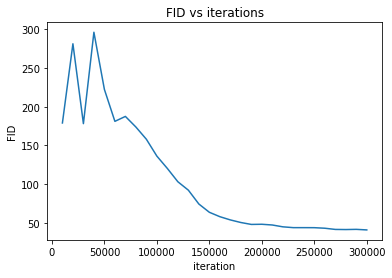

Best iteration: 300000.0
Best FID: 40.670504740609246


In [15]:
fids = np.array(fid_list)
plt.clf()
plt.plot(fids[:, 0], fids[:, 1])
plt.title('FID vs iterations')
plt.xlabel('iteration')
plt.ylabel('FID')
plt.show()

best_iteration_idx = np.argmin(fids[:, 1])
print('Best iteration:', fids[best_iteration_idx, 0])
print('Best FID:', np.min(fids[best_iteration_idx, 1]))

In [16]:
# Calculating the FID for the best checkpoint with 10000

best_iteration = iteration
checkpoint_samples_path = os.path.join(samples_folder, '{:d}_best.npy'.format(best_iteration))
if not os.path.exists(checkpoint_samples_path):
    # The path to the saved model.
    model_path = os.path.join(save_folder, 'checkpoint{}'.format(best_iteration))
    # The folder for saving the sampled images.
    checkpoint_samples_folder = os.path.join(samples_folder, '{:d}'.format(best_iteration))
    # Exponential Moving Average of the model is used for FID calculation.
    model.load_state_dict(torch.load(model_path)['model_ema'])
    samples = sample(model, 10000, noise_scales, args.eps, args.T, device)
else:
    samples = np.load(checkpoint_samples_path)
fid = test(test_loader, samples, device, args)
print('Calculated FID for the best checkpoint:'.format(best_iteration), fid)

Extracting features...


100%|███████████████████████████████████████████| 79/79 [01:24<00:00,  1.07s/it]


Calculated FID for the best checkpoint: 15.832438850109185


## Qualitative results

We present the samples generated with the best model. The sample quality is comparable to the ones in Figure 25 in [1]. The samples displayed below are not cherry-picked.

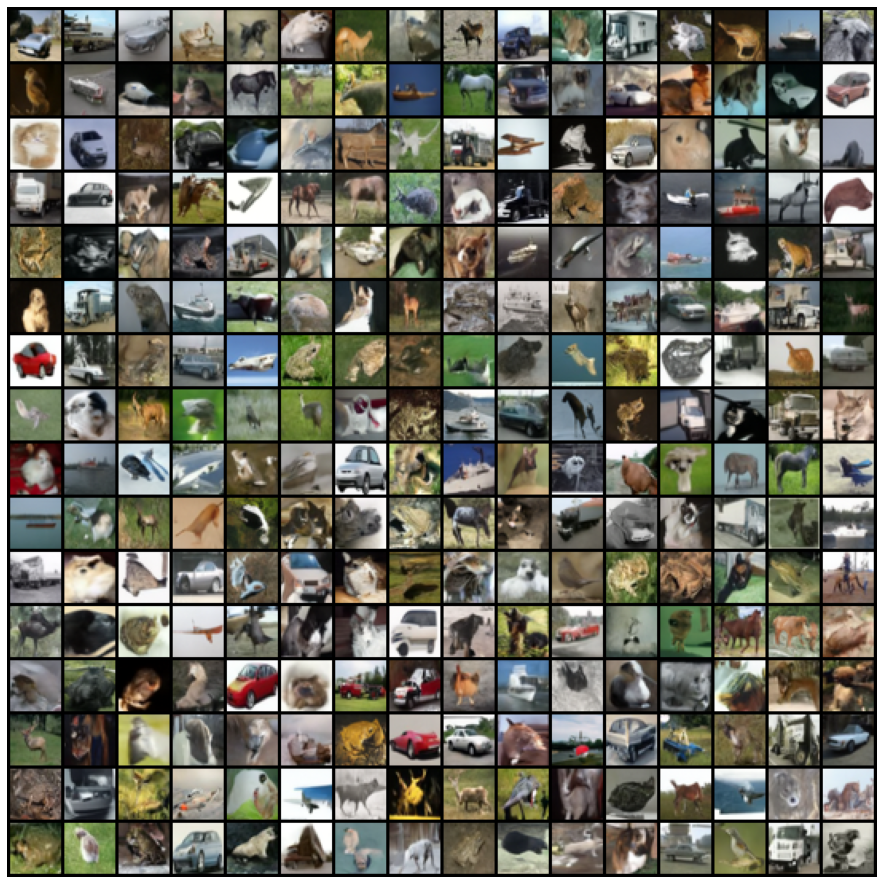

In [18]:
plt.clf()
best_fid_samples_path = os.path.join(samples_folder, '{:d}.npy'.format(lowest_iteration))
samples = np.load(best_fid_samples_path)
samples = torch.from_numpy(samples)
grid_width = 16
grid_height = 16
image_grid = torchvision.utils.make_grid(samples[:grid_width*grid_height], nrow=grid_width)
plt.rcParams['figure.figsize'] = [grid_height, grid_width]
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

## Challenges

- For us, the most time consuming and somewhat unclear part of the paper was the architectural details. We had to refer several papers and use our intuition to combine them to build our final model.

- In [2], they use RefineNet [3] architecture. However, they replaced the subsampling layers with dilated convolutions and the details of the dilated convolutions are left unclear. While implementing, we have assumed that the size of the output layer is preserved. Due to using dilated convolutions, the size of the receptive field is increased without using strides.

- In Appendix B.1 in [1], the size of the 3rd RefineBlock is reported to be 128. However, after examining the RefineNet architecture proposed in [3], we saw that the channel size of a RefineBlock should be determined according to the outputs of the corresponding ResNet blocks and in our model we had to use channel size of 256.

- While sampling from the model, the paper uses Annealed Langevin Dynamics and all the steps are detailed However, the initialization of the first noise sample (x_0) is not mentioned. So, we have randomly initialized x_0 with a uniform distribution from the [0,1) interval.

- The loss function is the squared error between the estimated score and the real score. We have tried both the sum of squared errors and the mean squared error. We have obtained better results with the mean squared error. The results presented in this report are from the mean reduction one.

- While calculating the Frechet Inception Distance, we used Schur Decomposition to calculate the square root of the covariance matrices as we could not find which operation is used in [4]. The operation could not be an element-wise square root as there can be negative elements. We also tried to use Cholesky decomposition, which gives lower/upper triangular results, but it gave exceptions during calculation. Therefore, we are not really sure if we calculated FID correctly.

- In [2], it is briefly mentioned that they pretrained the ResNet part of RefineNet as an autoencoder. However, this is not mentioned in [1]; therefore, we did not include it in our implementation.